이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## 1. 데이터 수집하기

### 1-1. 필요 라이브러리 및 데이터 불러오기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj62/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.shape

(98401, 2)

## 2. 데이터 전처리

### 2-1. 중복 데이터, 결측데이터 처리와 불용어처리

#### 컬럼명 변경

In [4]:
data = data.rename({'headlines':'Summary', 'text':'Text'}, axis = 1)

In [5]:
data.head()

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


#### Summary는 아주 간단한 요약들도 많아서 다른 내용이어도 중복가능
#### Text 자체가 중복이 된 경우는 중복 샘플이므로 제거

In [7]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


#### na값이 존재하는지 확인
* 존재하지 않음

In [8]:
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


#### na값이 남아 있을 수 있기 때문에 확인 후 제거

In [9]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


#### 맨 뒷부분에 추출적 요약을 하기 위해 복사본 생성(추출적 요약은 원본 그대로 사용)

In [10]:
data1 = data.copy()
data1

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [11]:
type(data1)

pandas.core.frame.DataFrame

### 2-2. 텍스트 정규화와 불용어 처리
* 텍스트 정규화는 같은 의미를 갖는 단어를 일치시키는 작업
* 불용어란 의미가 없는 단어 혹은 실제 분석에서 영향력이 없는 단어
  * 연산만 늘리거나 성능에 악영향을 끼칠 우려가 있음 --> 제거

In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 정규표현식을 활용한 전처리 함수
* 생성한 함수를 feature, target에 적용

In [14]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    # 위 단계를 거친 문장을 띄어쓰기 단위로 쪼개서 단어화해서 불용어사전과 비교하고 일치하지 않는 단어는 띄어쓰기로 붙여서 반환
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else: # remove_stopwords를 인자로 받지 않으면(Summary) 처리 X
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
# sentence = 'i ate breakfast'
# tokens = ''.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)

In [16]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [17]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [18]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

#### 정제 과정에서 null값이 생겼는지 확인

In [19]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

#### 생겼다면, 제거

In [20]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


In [21]:
print(data['Summary'][0])

upgrad learner switches to career in ml al with salary hike


### 2-3. 훈련, 테스트 데이터 분할

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


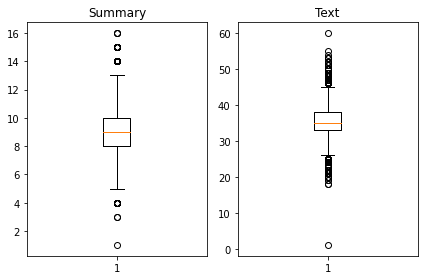

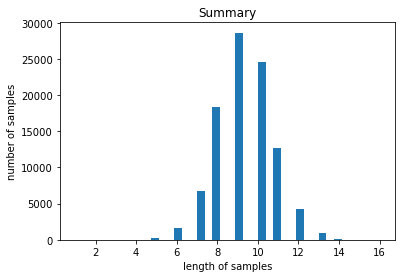

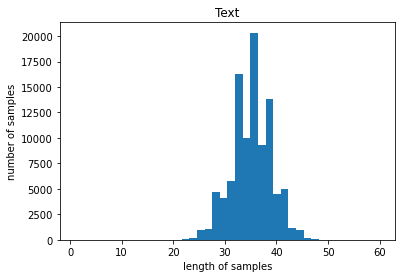

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
text_max_len = 50
summary_max_len = 8

In [24]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

#### 일정 기준으로 문장을 제거하면 어느정도의 자료를 활용할 수 있는지 확인

In [25]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


#### 일정 기준으로 문장 제거

In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 27105


### 2-4. 사용 데이터 준비
#### 시작 토큰과 종료 토큰 추가하기
* seq2seq 훈련을 위해 시작 토큰과 종료 토큰이 필요
* 시작 토큰: 'sostoken'
* 종료 토큰: 'eostoken'
  * 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장: decoder_input 
  * 디코더의 출력 또는 레이블에 해당하면서 종료 토큰이 맨 뒤에 붙는 문장: decoder_target

In [27]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


#### 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [28]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [29]:
encoder_input.shape

(27105,)

### 훈련 데이터와 테스트 데이터를 랜덤샘플링
#### encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

In [30]:
indices = np.arange(encoder_input.shape[0])
print(indices)
np.random.shuffle(indices)
print(indices)

[    0     1     2 ... 27102 27103 27104]
[ 4642 11583 13942 ...  6513   359 18011]


#### 샘플순서 정의

In [31]:
encoder_input = encoder_input[indices]# 해당 인덱스의 문장을 순서대로 입력
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [32]:
encoder_input[0]

'rjd leader tejashwi yadav monday said amendment liquor ban law bihar discount rich instead fine affluent class give get alcohol yadav added amendment introduced stop misuse innocent bring punishment proportion crime'

#### 테스트 데이터 크기 정의

In [33]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 5421


In [34]:
#### 정의한 테스트 데이터의 크기를 기준으로 전체 데이터 양분

In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


### 2-5. 정수 인코딩
* 단어집합 만들기
  * 컴퓨터가 텍스트를 인식할 수 있도록 정수로 변환

#### 원문에 해당하는 encoder_input_train의 단어 집합 생성

In [36]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

#### 등장 빈도에 대한 통계량 확인
* src_tokenizer.word_counts.items()에 단어와 각 단어의 등장 빈도수가 저장
* 등장 빈도수가 7회 미만인 단어들이 얼만큼의 비중을 차지하는지 확인

In [37]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42494
등장 빈도가 6번 이하인 희귀 단어의 수: 30744
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11750
단어 집합에서 희귀 단어의 비율: 72.34903751117805
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.278626245205189


#### 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
* fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성

In [38]:
# Data가 sort되어있나? 11,000개를 뭘 기준으로 자른건지?
src_vocab = 11000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 11,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [39]:
print(src_tokenizer.word_index)

{'said': 1, 'year': 2, 'india': 3, 'also': 4, 'us': 5, 'added': 6, 'people': 7, 'police': 8, 'government': 9, 'crore': 10, 'two': 11, 'first': 12, 'indian': 13, 'film': 14, 'president': 15, 'minister': 16, 'based': 17, 'state': 18, 'one': 19, 'world': 20, 'new': 21, 'reportedly': 22, 'company': 23, 'last': 24, 'million': 25, 'years': 26, 'old': 27, 'reports': 28, 'three': 29, 'country': 30, 'according': 31, 'would': 32, 'earlier': 33, 'delhi': 34, 'startup': 35, 'former': 36, 'lakh': 37, 'around': 38, 'claimed': 39, 'including': 40, 'trump': 41, 'time': 42, 'tuesday': 43, 'billion': 44, 'court': 45, 'friday': 46, 'like': 47, 'monday': 48, 'wednesday': 49, 'comes': 50, 'officials': 51, 'called': 52, 'day': 53, 'thursday': 54, 'pakistan': 55, 'killed': 56, 'made': 57, 'mumbai': 58, 'team': 59, 'accused': 60, 'congress': 61, 'announced': 62, 'singh': 63, 'chief': 64, 'found': 65, 'four': 66, 'group': 67, 'users': 68, 'party': 69, 'allegedly': 70, 'notably': 71, 'saturday': 72, 'national':

In [40]:
print(src_tokenizer.word_counts)

OrderedDict([('rjd', 47), ('leader', 697), ('tejashwi', 14), ('yadav', 193), ('monday', 1103), ('said', 10433), ('amendment', 19), ('liquor', 83), ('ban', 279), ('law', 423), ('bihar', 232), ('discount', 25), ('rich', 42), ('instead', 202), ('fine', 137), ('affluent', 1), ('class', 263), ('give', 218), ('get', 480), ('alcohol', 89), ('added', 2764), ('introduced', 149), ('stop', 220), ('misuse', 21), ('innocent', 23), ('bring', 118), ('punishment', 36), ('proportion', 9), ('crime', 162), ('tackle', 35), ('crimes', 84), ('like', 1133), ('cyber', 74), ('threats', 85), ('child', 273), ('pornography', 16), ('online', 566), ('stalking', 33), ('government', 2429), ('planning', 224), ('set', 563), ('warrior', 13), ('police', 2484), ('force', 293), ('reports', 1495), ('cwpf', 1), ('proposed', 198), ('raised', 716), ('lines', 63), ('central', 412), ('armed', 112), ('forces', 365), ('expected', 310), ('operate', 45), ('wing', 62), ('union', 566), ('home', 546), ('ministry', 561), ('information',

#### texts_to_sequences
* 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

In [41]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력(정수)
print(encoder_input_train[:3])

[[2925, 105, 7044, 691, 48, 1, 5752, 1768, 419, 237, 541, 4765, 3189, 640, 1041, 465, 591, 189, 1642, 691, 6, 5752, 947, 585, 5374, 5064, 1228, 3591, 9276, 850], [3677, 1738, 47, 1951, 1722, 432, 6460, 150, 3862, 9, 573, 154, 1951, 7381, 8, 391, 28, 1, 663, 102, 2243, 248, 1297, 8, 295, 364, 3024, 2281, 151, 160, 156, 1951, 320, 84, 2966], [2460, 19, 2, 27, 2967, 787, 1952, 3515, 3, 1952, 1928, 906, 884, 2967, 2598, 963, 101, 749, 75, 58, 73, 667, 3516, 470, 3, 1952, 1928, 787, 1739, 6731, 4914, 6214, 3765]]


#### Summary 데이터에 대해서도 동일한 작업 수행
*  케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [42]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

#### 데이터 통계량 확인
* 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [43]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18893
등장 빈도가 5번 이하인 희귀 단어의 수: 14276
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4617
단어 집합에서 희귀 단어의 비율: 75.56237760016937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.233852588680055


### 희귀단어 제거
* 훈련 데이터에서 등장 빈도로 차지하는 비중: 13.9%
* 인덱스가 2,000이 넘는 숫자 제거

In [44]:
tar_vocab = 4000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1068, 549, 5, 3694, 2758, 823], [1, 65, 4, 574, 54, 1458, 40, 853], [1, 105, 24, 8, 14, 1109, 1110], [1, 380, 352, 824, 1459, 9, 3314, 2534], [1, 25, 359, 5, 1208, 138, 3030, 986]]
target
decoder  [[1068, 549, 5, 3694, 2758, 823, 2], [65, 4, 574, 54, 1458, 40, 853, 2], [105, 24, 8, 14, 1109, 1110, 2], [380, 352, 824, 1459, 9, 3314, 2534, 2], [25, 359, 5, 1208, 138, 3030, 986, 2]]


#### 결측치 확인
* 빈도수가 낮은 단어로 구성되어있던 문장은 결측치로 변했을 가능성이 존재
* 비교적 길이가 짧은 decoder_input과 decoder_target에 존재할 가능성이 높음
* 앞뒤로 sos, eos를 결합했으니 결측치 문장은 길이가 1로 나타남
* 데이터의 길이가 1인 문장 추출해서 삭제

In [45]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 21682
훈련 레이블의 개수 : 21682
테스트 데이터의 개수 : 5420
테스트 레이블의 개수 : 5420


/home/aiffel-dj62/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩하기
* padding: 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞추는 작업
* post방식에 비해 pre방식이 효율이 좋은것으로 알려짐
* 그러나 LSTM의 경우, 마지막 문장(혹은 단어)에 정보가 최대한 유지된채 전달되어야 하므로 pre방식 사용

In [46]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

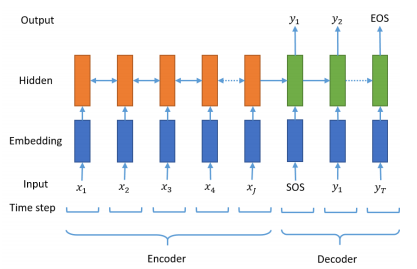

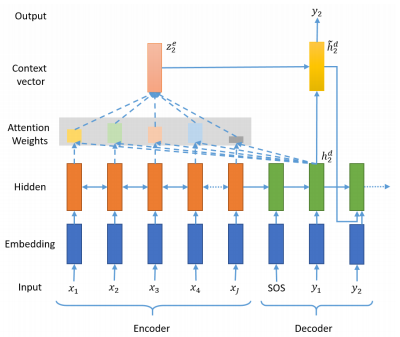

### 3-1. 모델 설계하기
* 함수형으로 설계
* 일반적인 LSTM을 사용한 seq2seq모델과 거의 유사(인코더, 디코더), 어텐션레이어를 추가

#### 개념
* 1. seq2seq를 사용합니다.
* 2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
* 3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
* 4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
* 5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
* 6.  계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

#### 인코더 설계
* hidden state: LSTM에서 얼만큼의 수용력(capacity)을 가질지 정하는 파라미터
* hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있음

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 디코더 설계
* 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일
* LSTM의 입력 정의 시 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 입력

In [48]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

#### 디코더의 출력층
* Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제
* Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용

In [49]:
# # 디코더의 출력층
# decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# # 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()

* 위에 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq
* 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 어텐션 메커니즘

### 3-2. 어텐션 매커니즘

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [51]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3-3. 모델 훈련하기
* EarlyStopping
  * val_loss(검증 데이터의 손실)을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회 관측(patiensce =2)되면 학습을 멈추도록 설정

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
85/85 [==============================] - 31s 363ms/step - loss: 5.9981 - val_loss: 5.5272
Epoch 2/50
85/85 [==============================] - 31s 360ms/step - loss: 5.5473 - val_loss: 5.3281
Epoch 3/50
85/85 [==============================] - 31s 360ms/step - loss: 5.3294 - val_loss: 5.1578
Epoch 4/50
85/85 [==============================] - 30s 356ms/step - loss: 5.1684 - val_loss: 5.0291
Epoch 5/50
85/85 [==============================] - 30s 352ms/step - loss: 5.0180 - val_loss: 4.9319
Epoch 6/50
85/85 [==============================] - 32s 382ms/step - loss: 4.8803 - val_loss: 4.8471
Epoch 7/50
85/85 [==============================] - 31s 361ms/step - loss: 4.7279 - val_loss: 4.7287
Epoch 8/50
85/85 [==============================] - 30s 356ms/step - loss: 4.5720 - val_loss: 4.6342
Epoch 9/50
85/85 [==============================] - 32s 372ms/step - loss: 4.4315 - val_loss: 4.5595
Epoch 10/50
85/85 [==============================] - 30s 353ms/step - loss: 4.3005 - val_lo

#### 시각화 및 결과
* 훈련과정을 시각적으로 확인

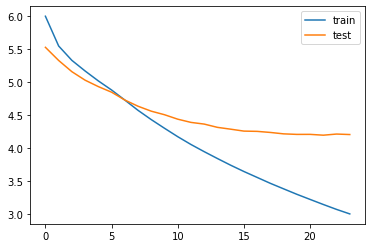

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3-4. 인퍼런스 모델 구현하기
* 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원
* 필요한 3개의 사전 준비

In [54]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 검증단계 모델 설계
* 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교
* 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 인퍼런스를 위한 모델을 별도 설계
* 인코더 모델과 디코더 모델을 분리해서 설계

#### 입력층 설계

In [55]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 출력층 설계

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기
* 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는것이 직관적
* Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

#### 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

#### 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [59]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre directed officials information broadcasting ministry departments refrain interacting media without authorisation authorities officials direct media press information bureau seek permission minister secretary ministry department meeting centre ordered 
실제 요약 : seek permission before media centre to officials 
예측 요약 :  govt orders for of


원문 : rare bowl made years ago chinese emperor auctioned million said bowl measures diameter sold within five minutes added three use beautiful pink 
실제 요약 : rare sells for crore 
예측 요약 :  world most expensive sold for crore


원문 : papers million documents exposing offshore dealings reportedly used like nike facebook several world figures including uk queen elizabeth files obtained german newspaper analysed journalists countries 
실제 요약 : what is the papers leak 
예측 요약 :  fined for for million


원문 : philippine militants pledged allegiance isis taken priest several worshippers hostage church vowed kill government forces recalled reports said 

예측 요약 :  man arrested for sexual assault in


원문 : england registered wicket victory second friday end india seven match winning streak cricket level three match series defeat india third year england three seven series take place bristol county ground sunday 
실제 요약 : england end india match winning streak level series 
예측 요약 :  india captain winning captain after cricket


원문 : speed installed ancient town beijing grand china officially described devices cover distance metres believed encourage pedestrians slow enjoy meanwhile people claimed meant 
실제 요약 : chinese tourist town installs speed for pedestrians 
예측 요약 :  world first hotel for years


원문 : billionaire investor warren buffett saw stocks owns make money past year gaining around billion value according fortune companies buffett berkshire hathaway currently owns seven risen whose gain much include tech giant apple banking major goldman sachs 
실제 요약 : billionaire buffett made lakh crore in year 
예측 요약 :  buffett buffett stake i

### 추출적 요약
* 주어진 텍스트를 사용하여 요약하였습니다. 처음 세 단락만 뽑아 각각 원본과 비교하였습니다.

#### summarize 사용하기

Summa의 summarize()의 인자
* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

* Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
* 문장 구분이 되어있지 않은 원문을 바로 입력으로 활용 가능

In [60]:
import requests
from summa.summarizer import summarize

In [61]:
textlist = data1['Text']
textlist[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [64]:
for i in range(len(textlist[:3])):
    print("Original:")
    print(data1['Text'][i])
    print("\n"+"Summary:")
    print(summarize(str(data1['Text'][i]), ratio=0.5), end="\n"+"============================================================================="+"\n")

Original:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.
Original:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Original:
New Zealand defeat

# 루브릭
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
   * 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행하였습니다.


2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
   * 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었습니다.


3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
   * 두 요약을 비교해보고자 하였으나, 추출적 요약은 원본에 있는 문장을 그대로 갖다 써야하는 특성상 최대한 원본에 가깝게 출력되어야 한다고 생각하여 전처리 하기 전 원본 Text데이터를 활용하였습니다. 따라서 두 문장을 단순 비교하진 못했지만, 추상적 요약을 원본과, 그리고 추출적 요약을 원본과 비교해볼 수 있었습니다.

# 회고

* 이번 노드는 처음 받았을 땐 무슨 소린지 이해가 안가서 코드만 복붙했었습니다. 그러다 CS231강의를 듣고 RNN의 특징과 작동 원리들을 배우고 나니 조금 이해가 편했습니다. RNN과 LSTM, seq2seq와 Attention등 여러 개념을 훑어보듯 학습할 수 있어 좋았습니다. 


* 아쉬웠던 점은 한번에 여러 개념을 도입하고 설명하여 아무래도 깊이 이해하기는 어려웠다는 점입니다. 이 부분은 개인적인 공부가 필요할 것으로 보입니다.


* 이번 노드를 진행하며 궁금했던 점은 자연어는 정성적인 지표밖에 없는것인지 하는 부분이었습니다. 아무래도 자연어라는 분야가 정량적으로 정해진 지표가 명확하지 않으니 성능이나 결과물을 판단하는것에 다소 어려움이 있다고 생각합니다. 이에 대한 판단 기준이라던지, 필요한 도메인이라던지 하는 부분에 대한 설명까지 있었으면 더 좋지 않았을까 싶습니다.

# 느낀점
* 단어를 요약하는것이 단순히 추출하는 기법을 사용하는 것이 아니라 해당 문서에 나타나지 않은 단어와 표현을 사용할 수 있다는 사실이 놀라웠습니다. 이는 모델이 작사가를 만들었을때처럼 단순히 단어의 순서를 학습하는 것이 아니라 문맥과 단어의 관계까지도 학습을 한다는 뜻이니까요. 이번 노드를 거치면서 자연어의 매력을 한층 더 알 수 있었습니다.